# Detect spots

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.plot as plot
import numpy as np
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.4.0


In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

# check input images are loaded
stack.check_input_data(path_input)

experiment_1_dapi_fov_1.tif is already in the directory
experiment_1_smfish_fov_1.tif is already in the directory


In this notebook, we show examples of **mRNAs detection**. We use 3D images. Three main steps are developed:
- Detection of spots as local maximum.
- Decomposition of clustered spots and dense regions.
- Detection of foci (a tight cluster of spots).

In [3]:
path = os.path.join(path_input, "experiment_1_smfish_fov_1.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

smfish channel
 shape: (23, 650, 500)
 dtype: uint16


In [4]:
rna_mip = stack.maximum_projection(rna)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))

smfish channel (2D maximum projection)
 shape: (650, 500)
 dtype: uint16


## Point Spread Function (PSF)

We model the **PSF** of each spot as a gaussian signal. Thus, we can **estimate the standard deviation** of this signal, in pixel, based on the metadata of the microscope used during the acquisition.

In [5]:
# parameters
voxel_size_z = 300
voxel_size_yx = 103
psf_z = 350
psf_yx = 150

# sigma
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
print("standard deviation of the PSF (z axis): {:0.3f} pixels".format(sigma_z))
print("standard deviation of the PSF (yx axis): {:0.3f} pixels".format(sigma_yx))

standard deviation of the PSF (z axis): 1.167 pixels
standard deviation of the PSF (yx axis): 1.456 pixels


## Spot detection

We assume **spot is a local maximum** in the smFISH channel. Three steps are required to detect them:
- Filter the smFISH channel to enhance the signal-to-noise ratio and denoise the image (`bigfish.stack.log_filter`).
- Detect the local maximum in the filtered image (`bigfish.detection.local_maximum_detection`).
- Remove the local maximum under a fixed threshold (`bigfish.detection.spots_thresholding`). To be robust, the thresholding should be applied on the filtered image. Thus, the threshold is set relatively to the filtered image values.
- If necessary, the optimal threshold can be estimated with `bigfish.detection.automated_threshold_setting` (applied on a filtered image).

All these steps are summarized in `bigfish.detection.detect_spots` that return the 2D or 3D coordinates of the detected spots.

In [6]:
spots, threshold = detection.detect_spots(
    rna, return_threshold=True, 
    voxel_size_z=voxel_size_z, voxel_size_yx=voxel_size_yx, psf_z=psf_z, psf_yx=psf_yx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (771, 3)
 dtype: int64
 threshold: 355.0


The previous steps can be computed separately.

In [7]:
# sigma
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)

# LoG filter
rna_log = stack.log_filter(rna, sigma)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, sigma)

# thresholding
threshold = detection.automated_threshold_setting(rna_log, mask)
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (771, 3)
 dtype: int64
 threshold: 355.0


**Radius** in pixels of the detected spots can be estimated from the microscope metadata as well. 

In [8]:
(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
print("radius z axis: {0:0.3f}".format(radius_z))
print("radius yx axis: {0:0.3f}".format(radius_yx))

radius z axis: 2.021
radius yx axis: 2.522


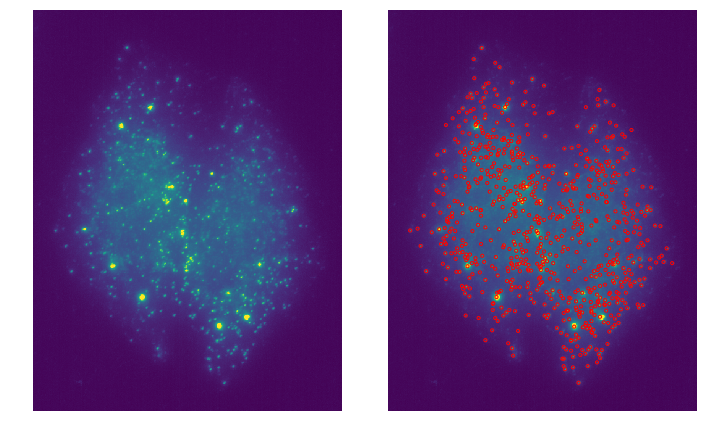

In [9]:
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True)

## Cluster decomposition

The detection of local maximum is not able to **decompose clustered mRNAs**. They appear as larger and brighter areas. Our current steps are:
- Denoise the smFISH channel by estimating then removing its background (`bigfish.stack.remove_background_gaussian`).
- Build a reference median spot from the individual predetected spots (`bigfish.detection.build_reference_spot`).
- Fit a gaussian signal on the reference spot (`bigfish.detection.modelize_spot`).
- Detect the potential clustered regions in the denoised image (large regions brighter than the reference spot (`bigfish.detection.get_clustered_region`).
- Use the fitted gaussian signal to fill as many spots in the clustered regions as possible (`bigfish.detection.fit_gaussian_mixture`).

All these steps are summarized in `bigfish.detection.decompose_cluster` that return the 2D or 3D coordinates of the detected spots outside and inside a cluster, additional information about the clusters themself and an image of the reference spot estimated.

In [10]:
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (771, 3)
 dtype: int64
detected spots after decomposition
 shape: (1165, 3)
 dtype: int64


The previous steps can be computed separately.

In [11]:
# sigma
sigma = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
large_sigma = tuple([sigma_ * 5 for sigma_ in sigma])

# denoising
rna_denoised = stack.remove_background_gaussian(rna, large_sigma)

# reference spot
reference_spot = detection.build_reference_spot(
    rna_denoised,
    spots,
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    alpha=0.7)

# fit a gaussian function on the reference spot
sigma_z, sigma_yx, amplitude, background = detection.modelize_spot(
    reference_spot, voxel_size_z, voxel_size_yx, psf_z, psf_yx)

# detect potential cluster regions
cluster_regions, spots_out_cluster, cluster_size = detection.get_clustered_region(
    rna_denoised, 
    spots,
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    beta=1)

# precompute gaussian function values
max_grid = max(200, cluster_size + 1)
precomputed_gaussian = detection.precompute_erf(
    voxel_size_z, voxel_size_yx, sigma_z, sigma_yx, max_grid)

# gaussian mixtures
spots_in_cluster, _ = detection.fit_gaussian_mixture(
    rna_denoised,
    cluster_regions,
    voxel_size_z,
    voxel_size_yx,
    sigma_z,
    sigma_yx,
    amplitude,
    background,
    precomputed_gaussian)

spots_post_decomposition = np.concatenate((spots_out_cluster, spots_in_cluster[:, :3]), axis=0)
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (771, 3)
 dtype: int64
detected spots after decomposition
 shape: (1165, 3)
 dtype: int64


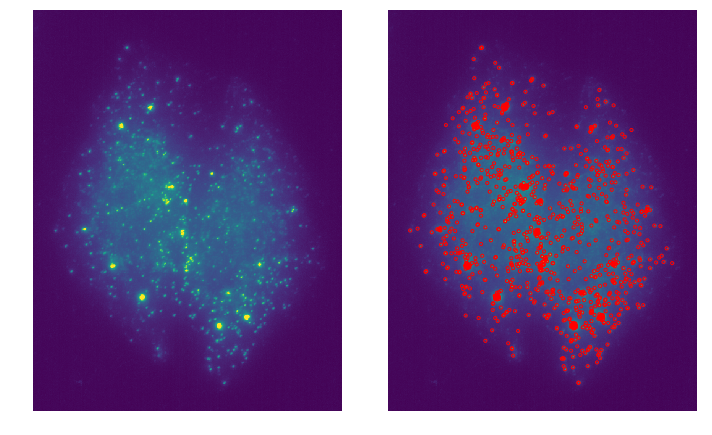

In [12]:
plot.plot_detection(rna_mip, spots_post_decomposition, radius=radius_yx, 
                    framesize=(10, 8), contrast=True)

The image of the **reference spot** can be used for safety checks. Indeed, a bad estimation would lead to a underestimate or overestimate the number of spots in the clusters. Enough samples of individual spots should be available to properly estimate a reference spot. 

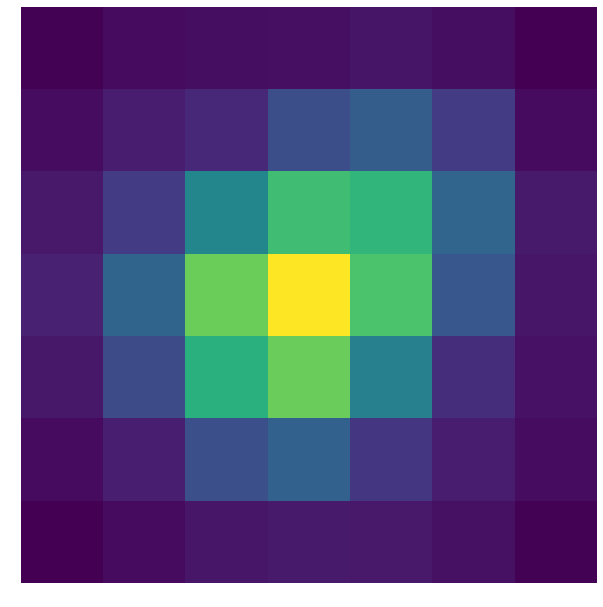

In [13]:
plot.plot_reference_spot(reference_spot, rescale=True)

## Foci detection

Two spots are considered connected if they localized within a specific radius (in nanometer). Above a minimum number of connected spots, a cluster is defined as a **foci**. This detection can be computed with `bigfish.detection.detect_foci`.

In [14]:
radius = 350
nb_min_spots = 4
spots_post_clustering, foci = detection.detect_foci(
    spots_post_decomposition, 
    voxel_size_z, voxel_size_yx, radius, nb_min_spots)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype))
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

detected spots after clustering
 shape: (1165, 4)
 dtype: int64
detected foci
 shape: (19, 5)
 dtype: int64


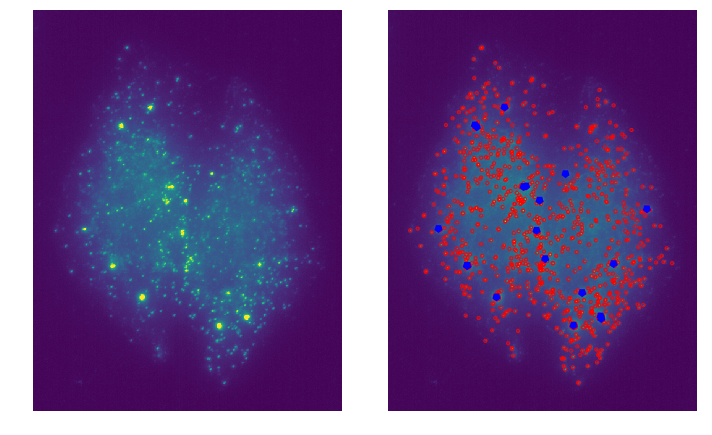

In [15]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, foci[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[radius_yx, radius_yx*2], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    framesize=(10, 8), 
                    contrast=True)

## Save results

Spots and foci coordinates can be saved in **npy files** (numpy dedicated format) or **csv files** using functions `bigfish.stack.save_array` and `bigfish.stack.save_data_to_csv` respectively.

In [16]:
# save in npy files
path = os.path.join(path_output, "spots.npy")
stack.save_array(spots_post_clustering, path)
path = os.path.join(path_output, "foci.npy")
stack.save_array(foci, path)

# save in csv files
path = os.path.join(path_output, "spots.csv")
stack.save_data_to_csv(spots_post_clustering, path)
path = os.path.join(path_output, "foci.csv")
stack.save_data_to_csv(foci, path)

## Detection in 2D or 3D

Based on the number of dimensions of the provided image, a 2D or 3D detection is performed and corresponding coordinates are returned. Parameters `voxel_size_z` and `psf_z` are only required for a 3D detection. The pipeline is the same for a 2D detection, but a slight underestimation of the number of spots can be expected.

In [17]:
spots, threshold = detection.detect_spots(
    rna_mip, return_threshold=True, 
    voxel_size_z=None, voxel_size_yx=voxel_size_yx, psf_z=None, psf_yx=psf_yx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (656, 2)
 dtype: int64
 threshold: 203.0


In [18]:
(radius_yx, radius_yx) = detection.get_radius(None, voxel_size_yx, None, psf_yx)
print("radius yx axis: {0:0.3f}".format(radius_yx))

radius yx axis: 2.060


In [19]:
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna_mip, spots, 
    voxel_size_z=None, voxel_size_yx=voxel_size_yx, psf_z=None, psf_yx=psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (656, 2)
 dtype: int64
detected spots after decomposition
 shape: (889, 2)
 dtype: int64


In [20]:
radius = 350
nb_min_spots = 4
spots_post_clustering, foci = detection.detect_foci(
    spots_post_decomposition, 
    voxel_size_z, voxel_size_yx, radius, nb_min_spots)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype))
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

detected spots after clustering
 shape: (889, 3)
 dtype: int64
detected foci
 shape: (16, 4)
 dtype: int64


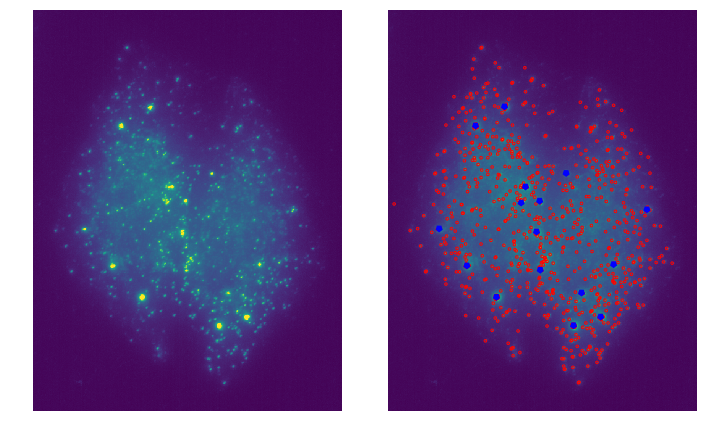

In [21]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, foci[:, :2]], 
                    shape=["circle", "polygon"], 
                    radius=[radius_yx, radius_yx*2], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    framesize=(10, 8), 
                    contrast=True)